In [17]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/cs229/sd_data/')
%cd drive/MyDrive/cs229/sd_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/cs229/sd_data'
/content/drive/.shortcut-targets-by-id/1hNmGL28ABDHXyODHwa494F88Q-xe1iut/sd_data


### Prepare training and testing datasets

In [18]:
seed = 0
data_split = [0.8, 0.1, 0.1]
batch_size = 128

In [19]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

TI_embeddings = []
CLIP_embeddings = []
for i in range(4):
  with open(f"{i}_AUG_TI_embeddings.pickle", "rb") as f:
      TI_embeddings.append(torch.Tensor(pickle.load(f)))
  with open(f"{i}_AUG_CLIP_embeddings.pickle", "rb") as f:
      CLIP_embeddings.append(torch.Tensor(pickle.load(f)))
TI_embeddings = torch.cat(TI_embeddings)
CLIP_embeddings = torch.cat(CLIP_embeddings)
input_dim, output_dim = CLIP_embeddings.shape[1], TI_embeddings.shape[1]

In [20]:
np.random.seed(seed)
train_idx, val_idx, test_idx = random_split(range(len(TI_embeddings)), data_split)

In [21]:
train_dset = TensorDataset(CLIP_embeddings[train_idx], TI_embeddings[train_idx])
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
x_val, y_val = CLIP_embeddings[val_idx], TI_embeddings[val_idx]
x_test, y_test = CLIP_embeddings[test_idx], TI_embeddings[test_idx]

In [22]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f"Device: {device}")

Device: cuda


### Define model

In [23]:
hidden_dim = 1024
lr = 1e-3
weight_decay = 5e-5

In [24]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
)
model = model.to(device=device)

opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

### Train model

In [12]:
n_steps = 50000
print_every = 2500
eval_every = 5000
save_every = 50000

In [13]:
def cycle(iterable):
  while True:
    for x in iterable:
      yield x

train_iterator = iter(cycle(train_loader))

In [25]:
x_val, y_val = x_val.to(device), y_val.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [208]:
import json

losses = {}
for step in range(1, n_steps+1):
  x, y = next(train_iterator)
  x, y = x.to(device), y.to(device)
  train_loss = F.mse_loss(model(x), y)
  opt.zero_grad()
  train_loss.backward()
  opt.step()
  losses[step] = {"Train loss": train_loss.item()}

  if step == 1 or step % eval_every == 0:
    with torch.no_grad():
      val_loss = F.mse_loss(model(x_val), y_val)
    losses[step]["Val loss"] = val_loss.item()
                 
  if step == 1 or step % print_every == 0:
    if step == 1 or step % eval_every == 0:
      print('Step %d: train loss = %.4f, val loss = %.4f' % (step, train_loss.item(), val_loss.item()))
    else:
      print('Step %d: train loss = %.4f' % (step, train_loss.item()))

  if step % save_every == 0:
    ckpt_name = f"KY_AUG_step{step}"
    save_data = {"model": model.state_dict(), "opt": opt.state_dict(), "step": step}
    torch.save(save_data, ckpt_name + ".pt")
    with open(ckpt_name + ".json", "w") as f:
      json.dump(losses, f)
  step += 1

with torch.no_grad():
  test_loss = F.mse_loss(model(x_test), y_test)
losses["Test loss"] = test_loss.item()

Step 1: train loss = 0.0235, val loss = 0.0318
Step 2500: train loss = 0.0167
Step 5000: train loss = 0.0090, val loss = 0.0269
Step 7500: train loss = 0.0093
Step 10000: train loss = 0.0102, val loss = 0.0251
Step 12500: train loss = 0.0093
Step 15000: train loss = 0.0092, val loss = 0.0250
Step 17500: train loss = 0.0090
Step 20000: train loss = 0.0097, val loss = 0.0252
Step 22500: train loss = 0.0106
Step 25000: train loss = 0.0092, val loss = 0.0252
Step 27500: train loss = 0.0093
Step 30000: train loss = 0.0099, val loss = 0.0241
Step 32500: train loss = 0.0092
Step 35000: train loss = 0.0088, val loss = 0.0264
Step 37500: train loss = 0.0089
Step 40000: train loss = 0.0110, val loss = 0.0242
Step 42500: train loss = 0.0088
Step 45000: train loss = 0.0092, val loss = 0.0237
Step 47500: train loss = 0.0089
Step 50000: train loss = 0.0083, val loss = 0.0250


### Evaluate model

#### AUG

In [26]:
ckpt_name = "KY_AUG_step50000"
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim),
)
opt = optim.Adam(model.parameters(), lr=lr)

save_data = torch.load(ckpt_name + ".pt", map_location=device)

model.load_state_dict(save_data["model"])
model = model.to(device=device)
opt.load_state_dict(save_data["opt"])

In [27]:
import json
with open(ckpt_name + ".json", "r") as f:
  loss_dict = json.load(f)

train_loss, val_loss = [], {}
for step in loss_dict.keys():
  train_loss.append(loss_dict[step]["Train loss"])
  if "Val loss" in loss_dict[step]:
    val_loss[int(step)] = loss_dict[step]["Val loss"]
train_loss = np.array(train_loss)

In [28]:
import pandas as pd
train_loss_df = pd.DataFrame({"train loss": train_loss})
train_ewm = train_loss_df["train loss"].ewm(alpha=0.005).mean().to_numpy()

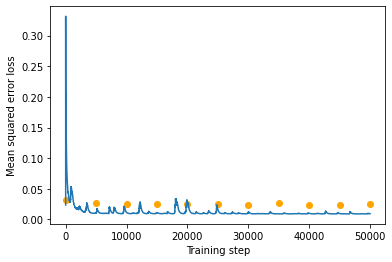

In [213]:
import matplotlib.pyplot as plt
plt.xlabel("Training step")
plt.ylabel("Mean squared error loss")
plt.plot(train_ewm);
plt.scatter(val_loss.keys(), val_loss.values(), c="orange");
plt.savefig("KY_training_loss.png", dpi=500, bbox_inches="tight", pad_inches=0)

In [29]:
model.eval()
final_train_loss = []
with torch.no_grad():
  for x_train, y_train in train_loader:
    x_train = x_train.to(device=device)
    y_train = y_train.to(device=device)
    final_train_loss.append(F.mse_loss(model(x_train), y_train).cpu().item())
final_train_loss = sum(final_train_loss)/len(final_train_loss)

with torch.no_grad():
  final_val_loss = F.mse_loss(model(x_val), y_val).item()

with torch.no_grad():
  final_test_loss = F.mse_loss(model(x_test), y_test).item()

print(f"Final MSE on training set: {final_train_loss}")
print(f"Final MSE on val set: {final_val_loss}")
print(f"Final MSE on test set: {final_test_loss}")

Final MSE on training set: 0.009350919686822277
Final MSE on val set: 0.009833630174398422
Final MSE on test set: 0.009503315202891827


### Inference

In [215]:
%%capture
!pip install git+https://github.com/openai/CLIP.git
!pip install -qq diffusers==0.8.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install accelerate

In [216]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", torch_dtype=torch.float16);
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer");

In [217]:
from PIL import Image
import os
import clip

with open("all_added_emb.pickle", "rb") as f:
  all_added_emb = pickle.load(f)

encoder, preprocess = clip.load("ViT-B/32");

In [218]:
def predict_ti_embedding_from_image(img_path, concept):
  img_tensor = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
  clip_embedding = encoder.encode_image(img_tensor).squeeze().to(device, dtype=torch.float32)
  print("Predicting textual inversion embedding from image...")
  with torch.no_grad():
    pred_ti_embedding = model(clip_embedding).to(device, dtype=torch.float16)

  new_token = f"pred_{concept}"
  print("Adding new concept to tokenizer...")
  num_added_tokens = tokenizer.add_tokens(new_token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {new_token}.")
  text_encoder.resize_token_embeddings(len(tokenizer))

  new_token_id = tokenizer.convert_tokens_to_ids(new_token)
  text_encoder.get_input_embeddings().weight.data[new_token_id] = pred_ti_embedding
  print("Done!")
  return new_token

In [219]:
# Load SD model
%%capture
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
).to(device);

In [220]:
concept = "cat-toy"
img_path = f"./sd-concepts-library/{concept}/0.jpeg"
new_token = predict_ti_embedding_from_image(img_path, concept)

Predicting textual inversion embedding from image...
Adding new concept to tokenizer...
Done!


In [221]:
prompt = f"A photo of a {new_token}"
print(prompt)
im1, im2, im3, im4 = pipe(prompt, num_images_per_prompt=4, num_inference_steps=50, guidance_scale=7.5)["images"]

A photo of a pred_cat-toy


  0%|          | 0/51 [00:00<?, ?it/s]

In [229]:
im1.save(f"KY_a_photo_of_a_{new_token}.png")